In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from list_prompt_family import ListPromptFamily
from prompt_registry import PROMPT_REGISTRY, ALL_PROMPTS
from wrap_registry import WRAP_REGISTRY
import numpy as np
import torch
from dotenv import load_dotenv
import os
from transformer_lens import HookedTransformer


/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/torch/onnx/_internal/_beartype.py:36: UserWarning: unhashable type: 'list'
  warnings.warn(f"{e}")


In [2]:
print("Available Prompts:")
for name in PROMPT_REGISTRY["list"]:
    print("-", name)

print("\nAvailable Wrap Styles:")
for name in WRAP_REGISTRY:
    print("-", name)


Available Prompts:
- print
- append
- add_all
- insert_middle
- swap_indices
- find_index

Available Wrap Styles:
- plain
- list
- interpreter
- system
- answer


In [3]:
# Example Prompt 
prompt = PROMPT_REGISTRY["list"]["append"]
case = prompt.create_case(inputs=[[1, 2, 3], 4])

print("Prompt (raw):\n", case.prompt)
print("Ground truth:", case.ground_truth)

wrap_fn = WRAP_REGISTRY["interpreter"]
wrapped_prompt = wrap_fn(prompt.prompt_fn(case.inputs), case.inputs)
print("Wrapped Prompt:\n", wrapped_prompt)

Prompt (raw):
 Append 4 to the end of this list [1, 2, 3]
Ground truth: [1, 2, 3, 4]
Wrapped Prompt:
 Pretend you are a Python interpreter.
TASK: Append 4 to the end of this list [1, 2, 3]
INPUT: [[1, 2, 3], 4]
OUTPUT:


In [4]:
# Generating multiple prompts
prompt.random_input_fn = lambda: [[1, 2, 3], np.random.randint(5, 10)]
cases = prompt.create_cases(n=3)

for c in cases:
    print("\nPrompt:")
    print(c.prompt)
    print("Expected:", c.ground_truth)



Prompt:
Append 7 to the end of this list [1, 2, 3]
Expected: [1, 2, 3, 7]

Prompt:
Append 9 to the end of this list [1, 2, 3]
Expected: [1, 2, 3, 9]

Prompt:
Append 5 to the end of this list [1, 2, 3]
Expected: [1, 2, 3, 5]


In [5]:
family = ListPromptFamily(min_val=0, max_val=5, append_max=10, list_size=3)

all_cases = family.generate_all(n=3)

for case in all_cases:
    print(f"\n{case.task_id} | wrap: {case.metadata['wrap_name']}")
    print(case.prompt)
    print("Expected:", case.ground_truth)



print-0 | wrap: plain
Print out this list of numbers: [2, 3, 1].
Expected: [2, 3, 1]

print-1 | wrap: plain
Print out this list of numbers: [3, 3, 1].
Expected: [3, 3, 1]

print-2 | wrap: plain
Print out this list of numbers: [4, 3, 1].
Expected: [4, 3, 1]

print-3 | wrap: list
Print out this list of numbers: [3, 0, 4].
Only output a list, no other information.
List: [
Expected: [3, 0, 4]

print-4 | wrap: list
Print out this list of numbers: [2, 4, 2].
Only output a list, no other information.
List: [
Expected: [2, 4, 2]

print-5 | wrap: list
Print out this list of numbers: [0, 1, 2].
Only output a list, no other information.
List: [
Expected: [0, 1, 2]

print-6 | wrap: interpreter
Pretend you are a Python interpreter.
TASK: Print out this list of numbers: [0, 2, 1].
INPUT: [[0, 2, 1]]
OUTPUT:
Expected: [0, 2, 1]

print-7 | wrap: interpreter
Pretend you are a Python interpreter.
TASK: Print out this list of numbers: [2, 4, 4].
INPUT: [[2, 4, 4]]
OUTPUT:
Expected: [2, 4, 4]

print-8 | 

In [6]:
load_dotenv()
hf_token = os.getenv("HF_TOKEN")

!huggingface-cli login --token {hf_token}

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
The token `transformerlens` has been saved to /Users/johnwu/.cache/huggingface/stored_tokens
Your token has been saved to /Users/johnwu/.cache/huggingface/token
Login successful.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [8]:
MODEL_NAME = "Phi-2"
torch.mps.empty_cache()
model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    device="mps",                
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model Phi-2 into HookedTransformer


In [9]:
family = ListPromptFamily(min_val=1, max_val=100, fill_mode="single_outlier", list_size=5)

cases = family.generate(prompt_name="find_index", wrap_name="answer", n=100)

for case in cases:
    print(f"\n{case.task_id}")
    print(case.prompt)
    print("Expected:", case.ground_truth)


find_index-0
Given a one indexed list [25, 87, 25, 25, 25], what is the index of the element 87?
Only output the answer, no other information.\ ANSWER: 
Expected: 2

find_index-1
Given a zero indexed list [2, 58, 58, 58, 58], what is the index of the element 2?
Only output the answer, no other information.\ ANSWER: 
Expected: 0

find_index-2
Given a zero indexed list [74, 74, 19, 74, 74], what is the index of the element 19?
Only output the answer, no other information.\ ANSWER: 
Expected: 2

find_index-3
Given a zero indexed list [17, 17, 17, 19, 17], what is the index of the element 19?
Only output the answer, no other information.\ ANSWER: 
Expected: 3

find_index-4
Given a one indexed list [78, 78, 78, 78, 70], what is the index of the element 70?
Only output the answer, no other information.\ ANSWER: 
Expected: 5

find_index-5
Given a one indexed list [41, 41, 41, 41, 9], what is the index of the element 9?
Only output the answer, no other information.\ ANSWER: 
Expected: 5

find

In [10]:
results = family.evaluate_all(model, max_tokens=20)

Evaluating prompt cases:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:   1%|          | 1/100 [00:05<09:15,  5.61s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:   2%|▏         | 2/100 [00:07<05:18,  3.25s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:   3%|▎         | 3/100 [00:11<06:15,  3.88s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:   4%|▍         | 4/100 [00:14<05:41,  3.56s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:   5%|▌         | 5/100 [00:18<05:36,  3.54s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:   6%|▌         | 6/100 [00:22<05:42,  3.65s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:   7%|▋         | 7/100 [00:25<05:28,  3.54s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:   8%|▊         | 8/100 [00:27<04:49,  3.15s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:   9%|▉         | 9/100 [00:31<04:55,  3.25s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  10%|█         | 10/100 [00:35<05:05,  3.40s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  11%|█         | 11/100 [00:38<05:13,  3.52s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  12%|█▏        | 12/100 [00:41<04:37,  3.16s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  13%|█▎        | 13/100 [00:44<04:39,  3.22s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  14%|█▍        | 14/100 [00:51<06:18,  4.41s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  15%|█▌        | 15/100 [01:06<10:34,  7.46s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  16%|█▌        | 16/100 [01:08<08:09,  5.83s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  17%|█▋        | 17/100 [01:11<07:10,  5.18s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  18%|█▊        | 18/100 [01:16<06:36,  4.84s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  19%|█▉        | 19/100 [01:19<06:04,  4.50s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  20%|██        | 20/100 [01:23<05:39,  4.24s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  21%|██        | 21/100 [01:26<05:18,  4.03s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  22%|██▏       | 22/100 [01:30<05:11,  3.99s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  23%|██▎       | 23/100 [01:39<06:53,  5.37s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  24%|██▍       | 24/100 [01:43<06:15,  4.94s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  25%|██▌       | 25/100 [01:46<05:40,  4.54s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  26%|██▌       | 26/100 [01:52<05:53,  4.78s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  27%|██▋       | 27/100 [01:58<06:23,  5.25s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  28%|██▊       | 28/100 [02:01<05:31,  4.60s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  29%|██▉       | 29/100 [02:06<05:20,  4.52s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  30%|███       | 30/100 [02:09<04:59,  4.28s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  31%|███       | 31/100 [02:12<04:15,  3.70s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  32%|███▏      | 32/100 [02:15<04:05,  3.60s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  33%|███▎      | 33/100 [02:18<03:55,  3.51s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  34%|███▍      | 34/100 [02:21<03:30,  3.18s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  35%|███▌      | 35/100 [02:24<03:37,  3.34s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  36%|███▌      | 36/100 [02:28<03:37,  3.40s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  37%|███▋      | 37/100 [02:31<03:30,  3.34s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  38%|███▊      | 38/100 [02:35<03:29,  3.38s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  39%|███▉      | 39/100 [02:39<03:35,  3.54s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  40%|████      | 40/100 [02:42<03:28,  3.48s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  41%|████      | 41/100 [02:55<06:14,  6.35s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  42%|████▏     | 42/100 [03:08<07:58,  8.24s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  43%|████▎     | 43/100 [03:10<06:08,  6.47s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  44%|████▍     | 44/100 [03:32<10:26, 11.19s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  45%|████▌     | 45/100 [03:40<09:14, 10.09s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  46%|████▌     | 46/100 [03:43<07:14,  8.04s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  47%|████▋     | 47/100 [03:46<05:48,  6.58s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  48%|████▊     | 48/100 [03:49<04:52,  5.62s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  49%|████▉     | 49/100 [03:52<04:01,  4.74s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  50%|█████     | 50/100 [03:56<03:37,  4.35s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  51%|█████     | 51/100 [03:58<03:03,  3.75s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  52%|█████▏    | 52/100 [04:02<02:59,  3.74s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  53%|█████▎    | 53/100 [04:04<02:35,  3.31s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  54%|█████▍    | 54/100 [04:08<02:40,  3.48s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  55%|█████▌    | 55/100 [04:13<02:52,  3.84s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  56%|█████▌    | 56/100 [04:16<02:39,  3.63s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  57%|█████▋    | 57/100 [04:19<02:33,  3.56s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  58%|█████▊    | 58/100 [04:30<03:59,  5.69s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  59%|█████▉    | 59/100 [04:32<03:09,  4.62s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  60%|██████    | 60/100 [04:36<03:00,  4.52s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  61%|██████    | 61/100 [04:40<02:48,  4.32s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  62%|██████▏   | 62/100 [04:43<02:30,  3.97s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  63%|██████▎   | 63/100 [04:47<02:20,  3.80s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  64%|██████▍   | 64/100 [04:52<02:38,  4.40s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  65%|██████▌   | 65/100 [04:58<02:49,  4.84s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  66%|██████▌   | 66/100 [05:01<02:18,  4.08s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  67%|██████▋   | 67/100 [05:05<02:15,  4.10s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  68%|██████▊   | 68/100 [05:08<02:04,  3.90s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  69%|██████▉   | 69/100 [05:12<02:00,  3.89s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  70%|███████   | 70/100 [05:15<01:52,  3.74s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  71%|███████   | 71/100 [05:18<01:37,  3.37s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  72%|███████▏  | 72/100 [05:22<01:42,  3.65s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  73%|███████▎  | 73/100 [05:25<01:32,  3.44s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  74%|███████▍  | 74/100 [05:27<01:15,  2.91s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  75%|███████▌  | 75/100 [05:28<01:03,  2.55s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  76%|███████▌  | 76/100 [05:30<00:55,  2.31s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  77%|███████▋  | 77/100 [05:31<00:45,  1.96s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  78%|███████▊  | 78/100 [05:33<00:41,  1.89s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  79%|███████▉  | 79/100 [05:35<00:38,  1.83s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  80%|████████  | 80/100 [05:37<00:35,  1.79s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  81%|████████  | 81/100 [05:38<00:33,  1.76s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  82%|████████▏ | 82/100 [05:40<00:32,  1.78s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  83%|████████▎ | 83/100 [05:41<00:27,  1.59s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  84%|████████▍ | 84/100 [05:42<00:23,  1.46s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  85%|████████▌ | 85/100 [05:44<00:22,  1.53s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  86%|████████▌ | 86/100 [05:46<00:21,  1.57s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  87%|████████▋ | 87/100 [05:47<00:20,  1.60s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  88%|████████▊ | 88/100 [05:50<00:22,  1.85s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  89%|████████▉ | 89/100 [05:52<00:20,  1.83s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  90%|█████████ | 90/100 [05:56<00:25,  2.55s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  91%|█████████ | 91/100 [06:00<00:26,  2.97s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  92%|█████████▏| 92/100 [06:02<00:21,  2.65s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  93%|█████████▎| 93/100 [06:04<00:17,  2.44s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  94%|█████████▍| 94/100 [06:05<00:12,  2.13s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  95%|█████████▌| 95/100 [06:07<00:10,  2.07s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  96%|█████████▌| 96/100 [06:09<00:08,  2.07s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  97%|█████████▋| 97/100 [06:11<00:06,  2.12s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  98%|█████████▊| 98/100 [06:13<00:04,  2.06s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  99%|█████████▉| 99/100 [06:15<00:01,  1.99s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases: 100%|██████████| 100/100 [06:17<00:00,  3.77s/it]


Evaluation Summary: 78/100 correct (78.0%)

Success: find_index-0
Prompt:
 Given a one indexed list [25, 87, 25, 25, 25], what is the index of the element 87?
Only output the answer, no other information.\ ANSWER: 
Expected: 2
Got     : <|endoftext|>Given a one indexed list [25, 87, 25, 25, 25], what is the index of the element 87?
Only output the answer, no other information.\ ANSWER: 
A: 1
<|endoftext|>

Success: find_index-1
Prompt:
 Given a zero indexed list [2, 58, 58, 58, 58], what is the index of the element 2?
Only output the answer, no other information.\ ANSWER: 
Expected: 0
Got     : <|endoftext|>Given a zero indexed list [2, 58, 58, 58, 58], what is the index of the element 2?
Only output the answer, no other information.\ ANSWER: 
0
<|endoftext|>

Success: find_index-3
Prompt:
 Given a zero indexed list [17, 17, 17, 19, 17], what is the index of the element 19?
Only output the answer, no other information.\ ANSWER: 
Expected: 3
Got     : <|endoftext|>Given a zero indexed 

# Targeted Failure Mode

In [ ]:
from utils.helpers import collect_failure_modes
pairs = collect_failure_modes(cases, 2)
print(pairs)

{'task_id': 'find_index-0', 'prompt': 'Given a one indexed list [25, 87, 25, 25, 25], what is the index of the element 87?\nOnly output the answer, no other information.\\ ANSWER: ', 'ground_truth': 2, 'exact_match': False, 'substring_match': True, 'output': '<|endoftext|>Given a one indexed list [25, 87, 25, 25, 25], what is the index of the element 87?\nOnly output the answer, no other information.\\ ANSWER: \nA: 1\n<|endoftext|>'}


TypeError: unhashable type: 'list'

In [25]:
# Zero-biased case
clean_case = cases[1]

corrupted_case = clean_case.copy()
corrupted_case.inputs = [[17, 74, 17, 17, 17], 74, 'zero']
corrupted_case.ground_truth = 2

# Comment out depending on sucess/failure
tmp = clean_case
clean_case = corrupted_case
corrupted_case = tmp

print(f"\n{clean_case}")
print(f"\n{corrupted_case}")

clean_result = clean_case.run_model(model, max_tokens=20)
corrupt_result = corrupted_case.run_model(model, max_tokens=20)


print(f"\n{clean_result['output']}")
print(f"\n{corrupt_result['output']}")



PromptCase(task_id='find_index-1', inputs=[[17, 74, 17, 17, 17], 74, 'zero'], prompt_fn=<function <lambda> at 0x31c525ca0>, ground_truth=2, metadata={'prompt_name': 'find_index', 'inputs': [[17, 74, 17, 17, 17], 74, 'one'], 'wrap_name': 'answer'}, wrap_fn=<function answer_only_wrap at 0x31c525ee0>, generated_output='<|endoftext|>Given a one indexed list [17, 74, 17, 17, 17], what is the index of the element 74?\nOnly output the answer, no other information.\\ ANSWER: \nA: 1\n<|endoftext|>', evaluation_result={'exact_match': False, 'substring_match': False, 'output': '<|endoftext|>Given a one indexed list [17, 74, 17, 17, 17], what is the index of the element 74?\nOnly output the answer, no other information.\\ ANSWER: \nA: 1\n<|endoftext|>'})

PromptCase(task_id='find_index-1', inputs=[[17, 74, 17, 17, 17], 74, 'one'], prompt_fn=<function <lambda> at 0x31c525ca0>, ground_truth=2, metadata={'prompt_name': 'find_index', 'inputs': [[17, 74, 17, 17, 17], 74, 'one'], 'wrap_name': 'answer'}

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


<|endoftext|>Given a zero indexed list [17, 74, 17, 17, 17], what is the index of the element 74?
Only output the answer, no other information.\ ANSWER: 
1
<|endoftext|>

<|endoftext|>Given a one indexed list [17, 74, 17, 17, 17], what is the index of the element 74?
Only output the answer, no other information.\ ANSWER: 
A: 1
<|endoftext|>


# Logit Attribution Example 

In [26]:
prompt = clean_case.prompt
tokens = model.to_tokens(prompt)
logits, cache = model.run_with_cache(tokens)

resid_final = cache["resid_post", -1][0]
unembed = model.W_U  

target_tok_id = model.to_single_token("1")  
baseline_tok_id = model.to_single_token("0")

logit_diff_direction = unembed[:, target_tok_id] - unembed[:, baseline_tok_id]
logit_contribution = resid_final @ logit_diff_direction


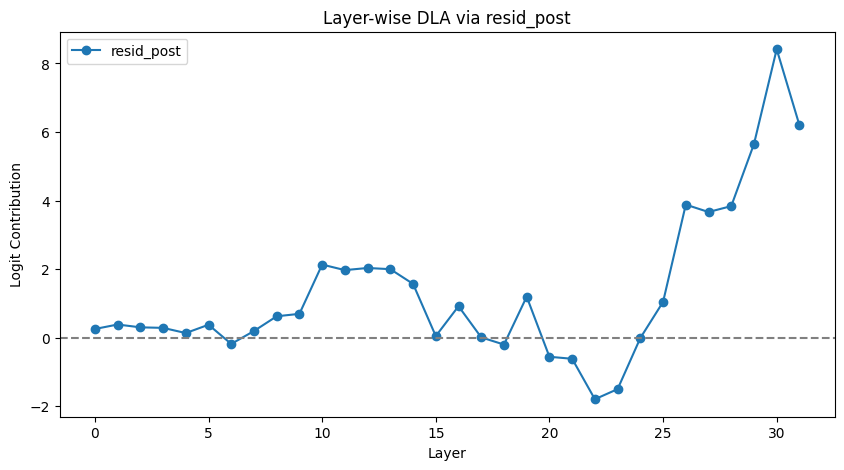

In [27]:
import matplotlib.pyplot as plt

n_layers = model.cfg.n_layers
logit_diff_direction = (unembed[:, target_tok_id] - unembed[:, baseline_tok_id]).detach()

resid_post_contribs = []

for layer in range(n_layers):
    resid_post = cache["resid_post", layer][0] 
    contrib_post = resid_post @ logit_diff_direction
    resid_post_contribs.append(contrib_post[-1].item())

plt.figure(figsize=(10, 5))
plt.plot(resid_post_contribs, label="resid_post", marker="o")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Layer")
plt.ylabel("Logit Contribution")
plt.title("Layer-wise DLA via resid_post")
plt.legend()
plt.show()

# Activation Patching

In [ ]:
# clean_string = clean_case.prompt
# corrupted_string = corrupted_case.prompt

# print(f"\nClean String: {clean_string}")
# print(f"\nCorrupted String: {corrupted_string}")

# answer_token_indices

# answer_token_indices = torch.tensor([[model.to_single_token(answers[i][j]) for j in range(2)] for i in range(len(answers))], device=model.cfg.device)
# print("Answer token indices", answer_token_indices)


Clean String: Given a zero indexed list [72, 72, 79, 72, 72], what is the index of the element 79?
Only output the answer, no other information.\ ANSWER: 

Corrupted String: Given a one indexed list [4, 3, 4, 4, 4], what is the index of the element 3?
Only output the answer, no other information.\ ANSWER: 


NameError: name 'answer_token_indices' is not defined